# 0. 강화학습을 이용한 체스 (Reinforcement Learning Chess) - 3

※본 커널은 캐글을 통해 공유된 https://www.kaggle.com/arjanso/reinforcement-learning-chess-3-q-networks 의 내용을 기반으로 작성되었습니다.



# Reinforcement Learning Chess
Reinforcement Learning Chess는 체스 AI를 개발하기 위해 강화 학습 알고리즘을 구현하는 일련의 Notebook입니다. 간단한 방법으로 다루어 질 수 있는 더 단순한 버전 (환경)으로 시작하여 본격적인 체스 인공 지능이 생길 때까지 이러한 개념을 점차적으로 확장합니다.

[**Notebook 1: Policy Iteration**](https://www.kaggle.com/arjanso/reinforcement-learning-chess-1-policy-iteration)  
[**Notebook 2: Model-free learning**](https://www.kaggle.com/arjanso/reinforcement-learning-chess-2-model-free-methods)  
[**Notebook 4: Policy Gradients**](https://www.kaggle.com/arjanso/reinforcement-learning-chess-4-policy-gradients)  
[**Notebook 5: Monte Carlo Tree Search**](https://www.kaggle.com/arjanso/reinforcement-learning-chess-5-tree-search)  

# Notebook III: Q-networks
이 notebook에서는 캡처 체스라는 간단한 버전의 체스를 구현합니다. 이 환경(environment)에서 agent(흰색 player)는 말을 잡으면 보상(reward)을 받습니다 (체크 메이트가 아님). 이 notebook을 실행한 후에는, 아래 GIF에 표시되는 것처럼 random oponnent에 대해 말을 캡처할 수 있는 agent를 갖게 됩니다. 이 notebook과 이전 notebook의 주요 차이점은 Q-table 대신 Q-network를 사용한다는 것입니다. Q-table은 훌륭하고 간단하지만 제한된 양의 동작값(action value)만 포함 할 수 있습니다. 체스의 상태(state) 공간 복잡도는 10<sup>47</sup>입니다. 말할 것도 없이, 이것은 Q-table에 넣기에는 너무 많은 정보입니다. 이러한 상황에서 지도 학습을 사용합니다. Q-network는 상태(state)에서 행동값(action value)으로의 일반화된 매핑을 나타낼 수 있습니다.

![](https://images.chesscomfiles.com/uploads/game-gifs/90px/green/neo/0/cc/0/0/aXFZUWpyN1Brc1BPbHQwS211WEhudkh6cXohMGFPMExPUTJNUTY4MDY1OTI1NFpSND8yOT85M1Y5MTA3MUxLQ3RDUkpDSjcwTE0wN293V0d6Rzc2cHhWTXJ6NlhzQVg0dUM0WGNNWDU,.gif)



## Import and Install

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import inspect

In [0]:
%load_ext autoreload
%autoreload 2

In [3]:
!pip install python-chess  # Python-Chess is the Python Chess Package that handles the chess environment
!pip install --upgrade git+https://github.com/arjangroen/RLC.git  # RLC is the Reinforcement Learning package

  Cloning https://github.com/arjangroen/RLC.git to /tmp/pip-req-build-0xc2jmwm
  Running command git clone -q https://github.com/arjangroen/RLC.git /tmp/pip-req-build-0xc2jmwm
  Created wheel for RLC: filename=RLC-0.3-cp36-none-any.whl size=22568 sha256=0e742b043b516bce6fc6ab36a1b9841c1688b79d155d84cfa38b2e465b17868f
  Stored in directory: /tmp/pip-ephem-wheel-cache-sippuz9c/wheels/04/68/a5/cb835cd3d76a49de696a942739c71a56bfe66d0d8ea7b4b446
Successfully built RLC


In [4]:
import chess
from chess.pgn import Game
import RLC
from RLC.capture_chess.environment import Board
from RLC.capture_chess.learn import Q_learning
from RLC.capture_chess.agent import Agent

Using TensorFlow backend.


# 3.1 The environment: Capture Chess
이 notebook에서는 환경(environment)을 실제 체스처럼 동작하도록 업그레이드 합니다. 주로 python-chess의 Board 객체를 기반으로합니다. 알고리즘이 수렴하기 쉽도록 일부 수정되었습니다.
* 환경(environment)이 재설정 된 후, 최대 25번 이동합니다.
* agent는 흰색 플레이어 입니다.
* 블랙 플레이어는 환경(environment)의 일부이며 무작위 움직임을 반환합니다.
* 보상(reward) 구조는 승/패/무승부가 아니라 검은 말을 잡는 것에 따릅니다.
    - pawn capture: +1
    - knight capture: +3
    - bishop capture: +3
    - rook capture: +5
    - queen capture: +9
* 상태(state) 는 8x8x8 배열로 나타냅니다.
    - Plane 0 represents pawns
    - Plane 1 represents rooks
    - Plane 2 represents knights
    - Plane 3 represents bishops
    - Plane 4 represents queens
    - Plane 5 represents kings
    - Plane 6 represents 1/총이동횟수(needed for markov property)
    - Plane 7 represents can-claim-draw
* 흰색 말은 값이 1 이고, 검은색 말은 값이 -1 입니다.
       


## Board representation of python-chess:

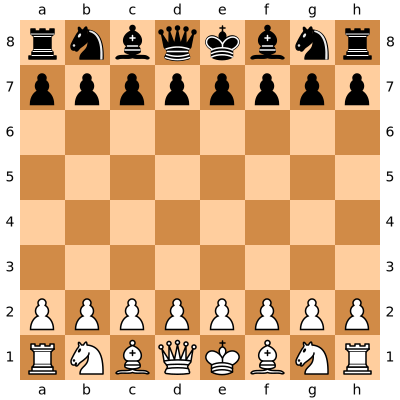

In [5]:
board = Board()
board.board

### Numerical representation of the pawns (layer 0)
다른 말을 보려면 첫번째 dimension 의 index 를 변경하십시요.

[0,::-1,:] 에서 0은 pawn 을 지정한 것 입니다.

In [11]:
board.layer_board[0,::-1,:].astype(int)

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

## The Agent
* agent 는 더 이상 하나의 말이 아니라 체스 플레이어입니다.
* action space는 64x64 = 4096 동작(action)으로 구성됩니다.
  * 말을 집어 올릴 수 있는 8x8 = 64 곳이 있습니다
  * 그리고 말을 내려 놓을 수 있는 또 다른 64 곳이 있습니다.
* 물론 특정 action만 합법적입니다. 특정 상태(state)에서 어떤 action 이 합법적인지는 환경(environment)의 일부입니다. (RL에서는 agent의 통제를 벗어난 모든 것이 환경의 일부로 간주 됨). python-chess 패키지를 사용하여 합법적 인 움직임을 선택할 수 있습니다. (AlphaZero는 유사한 접근 방식을 사용하는 것 같습니다.
https://ai.stackexchange.com/questions/7979/why-does-the-policy-network-in-alphazero-work)

### Implementation

In [7]:
board = Board()
agent = Agent(network='conv',gamma=0.1,lr=0.07)
R = Q_learning(agent,board)
R.agent.fix_model()
R.agent.model.summary()











Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
board_layer (InputLayer)        (None, 8, 8, 8)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 8, 8)      9           board_layer[0][0]                
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1, 8, 8)      9           board_layer[0][0]                
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 64)        0           conv2d_1[0][0]                   
__________________________________________________________________________________

In [8]:
print(inspect.getsource(agent.network_update))

    def network_update(self, minibatch):
        """
        Update the Q-network using samples from the minibatch
        Args:
            minibatch: list
                The minibatch contains the states, moves, rewards and new states.

        Returns:
            td_errors: np.array
                array of temporal difference errors

        """

        # Prepare separate lists
        states, moves, rewards, new_states = [], [], [], []
        td_errors = []
        episode_ends = []
        for sample in minibatch:
            states.append(sample[0])
            moves.append(sample[1])
            rewards.append(sample[2])
            new_states.append(sample[3])

            # Episode end detection
            if np.array_equal(sample[3], sample[3] * 0):
                episode_ends.append(0)
            else:
                episode_ends.append(1)

        # The Q target
        q_target = np.array(rewards) + np.array(episode_ends) * self.gamma * np.max(
            self.fi

### Q learning with a Q-network
**Theory**
- Q-network 는 일반적으로 선형회귀(linear regression) 또는 (deep) neural network입니다.
- 네트워크의 입력은 상태(state) (S)이고 출력은 각 동작(action)의 예상 동작값(action value) 입니다.(여기서는 4096 개의 값)
- 아이디어는 Q-table을 사용한 학습과 유사합니다. 할인 보상값(discounted reward) 과 최대 후속 상태 동작값(max successor state action value) 를 합한 값의 방향으로 Q 값을 업데이트 합니다.
- 우선 순위가 지정된 경험 재생을 사용하여 업데이트의 상관 관계를 제거했습니다. 더 자세히 알고 싶다면 참고 문헌의 링크를 확인하십시오.
  - 학습 과정을 안정화시키기 위해 fixed-Q 목표를 사용했습니다.

### Implementation
- linear network 와 convolutional network, 두 개의 network를 구축
- linear model 은 상태(state) (8,8,8)를 동작(action) (64,64)에 매핑하여 32k가 넘는 훈련 가능한 가중치를 제공합니다! 매개 변수 공유가 없기 때문에 매우 비효율적이지만 작동합니다.
- Convolutional model 은 2개의 1x1 convulutions를 사용하고 결과 배열의 outer product을 취합니다. 결과적으로 훈련 가능한 가중치는 18 개뿐입니다!
  - 장점 : 더 많은 매개 변수 공유-> 더 빠른 수렴
  - 단점 : 정보 손실-> 성능 저하
- 실제 체스 AI에는 더 큰 신경망이 필요합니다. 그러나 이제 신경망은 값어치 있는 말을 잡는 법을 배워야합니다.

In [9]:
print(inspect.getsource(R.play_game))

    def play_game(self, k, greedy=False, maxiter=25):
        """
        Play a game of capture chess
        Args:
            k: int
                game count, determines epsilon (exploration rate)
            greedy: Boolean
                if greedy, no exploration is done
            maxiter: int
                Maximum amount of steps per game

        Returns:

        """
        episode_end = False
        turncount = 0

        # Here we determine the exploration rate. k is divided by 250 to slow down the exploration rate decay.
        eps = max(0.05, 1 / (1 + (k / 250))) if not greedy else 0.

        # Play a game of chess
        while not episode_end:
            state = self.env.layer_board
            explore = np.random.uniform(0, 1) < eps  # determine whether to explore
            if explore:
                move = self.env.get_random_action()
                move_from = move.from_square
                move_to = move.to_square
            else:
                ac

### Demo

iter 0


iter 10
iter 20
iter 30
iter 40
iter 50
iter 60
iter 70
iter 80
iter 90
iter 100
iter 110
iter 120
iter 130
iter 140
iter 150
iter 160
iter 170
iter 180
iter 190
iter 200
iter 210
iter 220
iter 230
iter 240
iter 250
iter 260
iter 270
iter 280
iter 290
iter 300
iter 310
iter 320
iter 330
iter 340
iter 350
iter 360
iter 370
iter 380
iter 390
iter 400
iter 410
iter 420
iter 430
iter 440
iter 450
iter 460
iter 470
iter 480
iter 490
iter 500
iter 510
iter 520
iter 530
iter 540
iter 550
iter 560
iter 570
iter 580
iter 590
iter 600
iter 610
iter 620
iter 630
iter 640
iter 650
iter 660
iter 670
iter 680
iter 690
iter 700
iter 710
iter 720
iter 730
iter 740


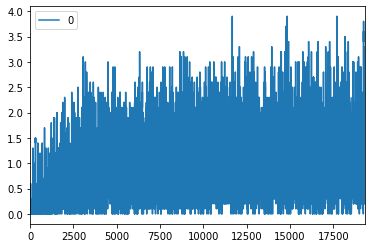

In [12]:
pgn = R.learn(iters=750)

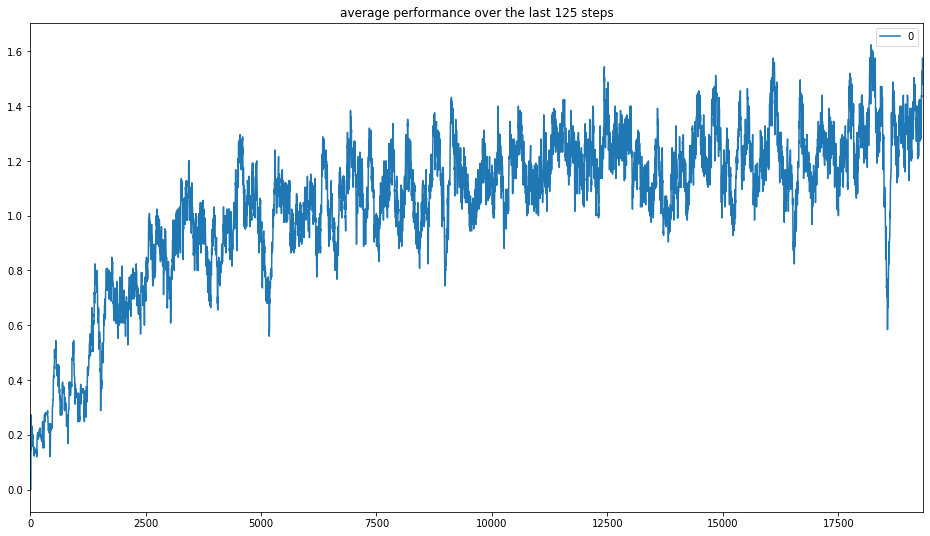

In [13]:
reward_smooth = pd.DataFrame(R.reward_trace)
reward_smooth.rolling(window=125,min_periods=0).mean().plot(figsize=(16,9),title='average performance over the last 125 steps')

PGN 파일이 출력 폴더로 내보내집니다. [chess.com analysis board](https://www.chess.com/analysis) 에 붙여 넣어 분석할 수 있습니다

In [0]:
with open("final_game.pgn","w") as log:
    log.write(str(pgn))

# 3.2 Learned action values analysis
네트워크는 무엇을 배웠습니까? 아래 코드는 모든 흰색말에 대해 모든 검은색 말을 잡는 동작값(action value)을 확인합니다.
- 검은색 말을 잡기 위한 동작값(action value)이 환경(environment)에 설정한 (Reinfeld) 보상(reward)과 비슷할 것으로 기대합니다.
- 물론 동작값(action value)은 블랙 플레이어에 의해서 다시 잡히는 위험과 연속으로 말을 잡는 기회에 따라 달라집니다.

In [0]:
board.reset()
bl = board.layer_board
bl[6,:,:] = 1/10  # Assume we are in move 10
av = R.agent.get_action_values(np.expand_dims(bl,axis=0))

av = av.reshape((64,64))

p = board.board.piece_at(20)#.symbol()


white_pieces = ['P','N','B','R','Q','K']
black_piece = ['_','p','n','b','r','q','k']

df = pd.DataFrame(np.zeros((6,7)))

df.index = white_pieces
df.columns = black_piece

for from_square in range(16):
    for to_square in range(30,64):
        from_piece = board.board.piece_at(from_square).symbol()
        to_piece = board.board.piece_at(to_square)
        if to_piece:
            to_piece = to_piece.symbol()
        else:
            to_piece = '_'
        df.loc[from_piece,to_piece] = av[from_square,to_square]
        
        

* ###흰색(대문자) 말로 검은색(소문자) 말을 잡기 위한 학습된 동작값(action value)입니다. 밑줄은 아무 것도 못 잡는 것을 나타냅니다.

In [16]:
df[['_','p','n','b','r','q']]

,_,p,n,b,r,q
P,0.798019,1.563570,3.540396,3.993215,6.070866,9.135963
N,0.720169,1.411037,3.195016,3.603660,5.478627,8.244712
B,0.737288,1.444579,3.270964,3.689322,5.608859,8.440696
R,0.673799,1.320183,2.989294,3.371626,5.125867,7.713848
Q,0.661777,1.296630,2.935962,3.311474,5.034418,7.576227
K,0.666056,1.305012,2.954942,3.332881,5.066963,7.625205


# References
Reinforcement Learning: An Introduction  
> Richard S. Sutton and Andrew G. Barto  
> 1st Edition  
> MIT Press, march 1998  

RL Course by David Silver: Lecture playlist  
> https://www.youtube.com/watch?v=2pWv7GOvuf0&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ  

Experience Replay  
> https://datascience.stackexchange.com/questions/20535/what-is-experience-replay-and-what-are-its-benefits